In [1]:
import os
import sys
import csv
import numpy as np

# Add the path to the custom library to the system path
sys.path.append('..')

# Import the module from the custom library
from src.core.utils.constants import EPSILON
from src.architectures.sequential import Sequential
from src.core.utils import data_analysis, data_processing, context_manager
from src import Tensor, layers, loss_functions, optimizers, metrics, callbacks

### Constants and Hyperparameters

In [2]:
# Path to where the model will be saved
model_path = os.path.join(os.getcwd(), 'checkpoints', 'weather_prediction')
dataset_path = os.path.join(os.getcwd(), 'dataset', 'weather.csv')

In [3]:
train_test_split_pct = 0.2 # Percentage of samples to use for testing
train_valid_split = 0.2 # Percentage of samples to use for validation
learning_rate = 3e-4 # Learning rate for the optimizer
batch_size = 16 # Number of samples to use for each batch
epochs = 50 # Number of epochs to train the model
seq_len = 24 # Length of the input sequences
seed = 1234 # Seed for reproducibility

In [4]:
# Set the seed for reproducibility
np.random.seed(seed)

### Data loading

In [5]:
# Load the dataset
def load_weather_data(file_path: str) -> list[dict]:
    """
    Load weather data from a CSV file.
    
    Parameters:
    - file_path: str, path to the CSV file
    
    Returns:
    - data: list[dict], list of dictionaries containing the weather data
    """
    
    # Read the CSV file
    with open(file_path, 'r') as file:
        # Create a CSV reader object
        reader = csv.DictReader(file)
        
        # Iterate over the rows in the CSV file
        return [row for row in reader]

In [6]:
def build_sequences(data: list[dict], input_keys: list[str], label_keys: list[str], seq_length: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Build sequences of weather data for training the model.
    
    Parameters:
    - data: list[dict], list of dictionaries containing the data
    - input_keys: list[str], keys to use as input features
    - label_keys: list[str], keys to use as labels
    - seq_length: int, length of the input sequences
    
    Returns:
    - tuple[np.ndarray, np.ndarray], tuple containing the input features and labels
    """
    
    # Initialize lists to hold the features and labels
    features = []
    labels = []

    # Iterate over the weather data to create sequences
    for i in range(len(data) - seq_length):
        # Create a sequence of input features
        seq = []
        
        # Iterate over the sequence length to build the input features
        for j in range(seq_length):
            # Get the sample at the current index
            sample = data[i + j]
            
            # Convert the sample to a float, defaulting to 0.0 if empty and append to the sequence
            seq.append([float(sample[k]) if sample[k] != '' else 0.0 for k in input_keys])
        
        # Get the label for the current sequence
        label_sample = data[i + seq_length]
        
        # Convert the label to a float, defaulting to 0.0 if empty
        label = [float(label_sample[k]) if label_sample[k] != '' else 0.0 for k in label_keys]
        
        # Append the sequence and label to the respective lists
        features.append(seq)
        labels.append(label)

    # Convert the features and labels to numpy arrays
    return np.array(features, dtype=np.float32), np.array(labels, dtype=np.float32)

In [7]:
# Load the weather data
weather_data = load_weather_data(dataset_path)

In [8]:
# Build sequences of input features and labels
features, labels = build_sequences(
    data = weather_data,
    input_keys = ['tmax', 'tmin', 'rain'],
    label_keys = ['tmax_tomorrow'],
    seq_length = seq_len
)

# Convert features and labels to Tensor objects
features = Tensor(np.array(features, dtype=np.float32))
labels = Tensor(np.array(labels, dtype=np.float32))

# Split the dataset into training, validation, and testing sets
X_train, X_test, y_train, y_test = data_processing.split_data((features, labels), train_test_split_pct, shuffle=True)
X_train, X_valid, y_train, y_valid = data_processing.split_data((X_train, y_train), train_valid_split, shuffle=True)

# Print the dataset information
print('Training set:', X_train.shape(), y_train.shape())
print('Validation set:', X_valid.shape(), y_valid.shape())
print('Testing set:', X_test.shape(), y_test.shape())

Training set: (8631, 24, 3) (8631, 1)
Validation set: (2157, 24, 3) (2157, 1)
Testing set: (2697, 24, 3) (2697, 1)


### Data preprocessing

In [9]:
def compute_normalization_stats(X: Tensor) -> tuple[np.ndarray, np.ndarray]:
    """
    Computes the mean and standard deviation for each feature across all samples and all time steps.

    Parameters:
    - X (Tensor): Input tensor of shape (N, T, F)

    Returns:
    - mean (np.ndarray): Feature-wise mean, shape (F,)
    - std (np.ndarray): Feature-wise std, shape (F,)
    """
    
    # Reshape the tensor to collapse the N and T dimensions
    data = X.data.reshape(-1, X.shape()[-1])
    
    # Compute the mean and standard deviation for each feature
    mean = data.mean(axis=0)
    std = data.std(axis=0) + EPSILON
    
    # Return the mean and standard deviation
    return mean, std

In [10]:
def normalize_data(X: Tensor, mean: np.ndarray, std: np.ndarray) -> Tensor:
    """
    Applies z-score normalization using precomputed mean and std.

    Parameters:
    - X (Tensor): Input tensor of shape (N, T, F)
    - mean (np.ndarray): Feature-wise mean, shape (F,)
    - std (np.ndarray): Feature-wise std, shape (F,)

    Returns:
    - Tensor: Normalized tensor
    """
    
    # Normalize the data using the mean and std
    norm_data = (X.data - mean) / std
    
    # Return a new Tensor object with the normalized data
    return Tensor(norm_data)

In [11]:
# Compute normalization statistics for the training data
mean, std = compute_normalization_stats(X_train)

# Normalize the training, validation, and testing data
X_train = normalize_data(X_train, mean, std)
X_valid = normalize_data(X_valid, mean, std)
X_test = normalize_data(X_test, mean, std)

### Building the model

In [12]:
# Instantiating the model
model = Sequential(
    name = "Weather Prediction Model",
    modules = [
        layers.RNN(
            num_layers = 8,
            num_units = 64,
            dropout = 0.1,
        ),
        layers.LayerNormalization(),
        layers.Dense(num_units=y_train.shape()[-1])
    ]
)

# Initialize the optimizer
optimizer = optimizers.Adam(learning_rate=learning_rate)

# Initialize the loss function
loss_fn = loss_functions.MeanSquareError()

### Initializing the model

In [13]:
# Call the model with a first batch to initialize the weights
# This is not necessary, but it is useful to know the input size

# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    model.eval()
    
    # Call the model with a batch of data to initialize it
    out = model(X_train[:batch_size])

In [14]:
# Display the model summary
model.summary(recursive=True)

Weather Prediction Model (Sequential) [output_shape=(16, 1), params=62849]
└── weather_prediction_model.modules (ModuleList) [output_shape=(16, 1), params=62849]
    ├── module_list.0 (RNN) [output_shape=(16, 64), params=62656]
    │   └── rnn.dropout_layer (Dropout) [output_shape=(16, 64), params=0]
    ├── module_list.1 (LayerNormalization) [output_shape=(16, 64), params=128]
    └── module_list.2 (Dense) [output_shape=(16, 1), params=65]


### Training the model

In [15]:
history = model.fit(
    X_train = X_train, 
    y_train = y_train,
    optimizer = optimizer,
    loss_fn = loss_fn,
    X_valid = X_valid,
    y_valid = y_valid,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = [callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50 --> loss: 3123.9720 | Validation loss: 2134.7034                                                   
Epoch 2/50 --> loss: 1299.4012 | Validation loss: 598.2453                                                   
Epoch 3/50 --> loss: 292.4505 | Validation loss: 113.6101                                                   
Epoch 4/50 --> loss: 85.0505 | Validation loss: 71.6382                                                   
Epoch 5/50 --> loss: 72.4998 | Validation loss: 70.7774                                                   
Epoch 6/50 --> loss: 104.1985 | Validation loss: 70.5950                                                   
Epoch 7/50 --> loss: 54.6285 | Validation loss: 42.3090                                                   
Epoch 8/50 --> loss: 42.6778 | Validation loss: 40.9956                                                   
Epoch 9/50 --> loss: 41.2421 | Validation loss: 40.4289                                                   
Epoch 10/50 --> loss: 39.89

In [16]:
# Save the model
model.save(model_path)

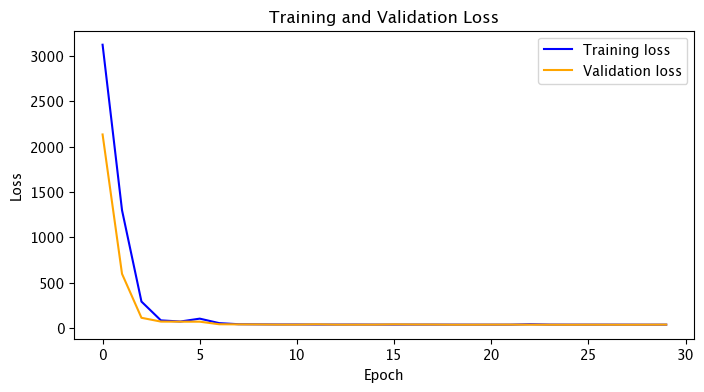

In [17]:
# Plot the training and validation loss
data_analysis.plot_history(model.history["loss"].data, model.history["val_loss"].data, "Training and Validation Loss", "Epoch", "Loss")

### Evaluation

In [18]:
# Disable gradient computation
with context_manager.no_grad():
    # Set the model in evaluation mode
    model.eval()
    
    # Compute the predictions
    predictions = model(X_test)

In [19]:
# Calculate the mean absolute error
mae = metrics.mean_absolute_error(y_test, predictions)

# Print the mean absolute error
print("Mean Absolute Error:", mae.data)

Mean Absolute Error: 4.2687235
